In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install GPy
import GPy
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

     |████████████████████████████████| 512.6MB 1.2MB/s 
ERROR: fastai 1.0.52 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 880kB 9.5MB/s 
     |████████████████████████████████| 71kB 25.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [0]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [0]:
class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

In [0]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                        learn_rate=1e-2, batch_size=batch_size, no_batches=1)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss = 356.468, KL loss = 2120.229
Epoch:   101/ 2000, Fit loss = 120.848, KL loss = 1826.297
Epoch:   201/ 2000, Fit loss =  97.054, KL loss = 1740.495
Epoch:   301/ 2000, Fit loss =  51.885, KL loss = 1668.559
Epoch:   401/ 2000, Fit loss =  57.564, KL loss = 1605.742
Epoch:   501/ 2000, Fit loss =  47.118, KL loss = 1548.583
Epoch:   601/ 2000, Fit loss =  42.134, KL loss = 1491.491
Epoch:   701/ 2000, Fit loss =  27.443, KL loss = 1438.303
Epoch:   801/ 2000, Fit loss =  28.225, KL loss = 1396.136
Epoch:   901/ 2000, Fit loss =  16.998, KL loss = 1358.076
Epoch:  1001/ 2000, Fit loss =  19.152, KL loss = 1311.681
Epoch:  1101/ 2000, Fit loss =  17.940, KL loss = 1272.627
Epoch:  1201/ 2000, Fit loss =  24.178, KL loss = 1241.902
Epoch:  1301/ 2000, Fit loss =  27.717, KL loss = 1213.660
Epoch:  1401/ 2000, Fit loss =  18.085, KL loss = 1181.425
Epoch:  1501/ 2000, Fit loss =  17.523, KL loss = 1159.974
Epoch:  1601/ 2000, Fit loss =  15.268, KL loss = 1140.0

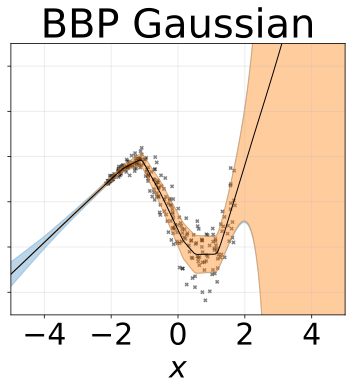

In [0]:
samples, noises = [], []
for i in range(100):
    preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
    samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
    noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

samples = np.array(samples)
noises = np.array(noises)
means = samples.mean(axis = 0)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
aleatoric = np.minimum(aleatoric, 10e3)
epistemic = np.minimum(epistemic, 10e3)

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

x_mean, x_std = x_train.mean(), x_train.var()**0.5
plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP Gaussian', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')

files.download("bbp_hetero.pdf")

plt.show()

# UCI dataset fitting

In [0]:
class BBP_Heteroscedastic_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model_UCI, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, num_units, gaussian(0, 1))
        self.layer3 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

def train_BBP(data, n_splits, num_epochs, num_units, learn_rate, log_every):
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for i, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % i)

        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        batch_size, nb_train = len(x_train), len(x_train)

        net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model_UCI(input_dim=x_test.shape[-1], output_dim=1, num_units=num_units),
                                                learn_rate=1e-2, batch_size=batch_size, no_batches=1)

        fit_loss_train = np.zeros(num_epochs)
        KL_loss_train = np.zeros(num_epochs)
        total_loss = np.zeros(num_epochs)

        best_net, best_loss = None, float('inf')

        for i in range(num_epochs):

            fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 20)
            fit_loss_train[i] += fit_loss.cpu().data.numpy()
            KL_loss_train[i] += KL_loss.cpu().data.numpy()

            total_loss[i] = fit_loss_train[i] + KL_loss_train[i]

            if fit_loss < best_loss:
                best_loss = fit_loss
                best_net = copy.deepcopy(net.network)

            if i % log_every == 0 or i == num_epochs - 1:

                train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
                test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

                print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                      (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                       -test_losses.mean() - np.log(y_stds)[0], y_stds*train_rmse, y_stds*test_rmse))


        train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
        test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

        train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
        test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

        train_rmses.append(y_stds*train_rmse)
        test_rmses.append(y_stds*test_rmse)

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))

    return best_net

# Housing dataset

In [0]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 18:12:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data’

housing.data        100%[===================>]  47.93K   170KB/s    in 0.3s    

2019-05-17 18:12:31 (170 KB/s) - ‘housing.data’ saved [49082/49082]



In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -3.611, Test loglik = -3.657, Train RMSE = 9.008, Test RMSE = 9.501
Epoch: 011/100, Train loglik = -3.138, Test loglik = -3.170, Train RMSE = 5.351, Test RMSE = 6.452
Epoch: 021/100, Train loglik = -2.770, Test loglik = -2.685, Train RMSE = 4.232, Test RMSE = 2.882
Epoch: 031/100, Train loglik = -2.606, Test loglik = -2.447, Train RMSE = 4.026, Test RMSE = 2.928
Epoch: 041/100, Train loglik = -2.707, Test loglik = -2.665, Train RMSE = 3.933, Test RMSE = 2.529
Epoch: 051/100, Train loglik = -2.546, Test loglik = -2.411, Train RMSE = 3.717, Test RMSE = 2.476
Epoch: 061/100, Train loglik = -2.302, Test loglik = -2.497, Train RMSE = 3.647, Test RMSE = 2.659
Epoch: 071/100, Train loglik = -2.511, Test loglik = -2.366, Train RMSE = 3.598, Test RMSE = 2.449
Epoch: 081/100, Train loglik = -2.318, Test loglik = -2.232, Train RMSE = 3.583, Test RMSE = 2.681
Epoch: 091/100, Train loglik = -2.329, Test loglik = -2.307, Train RMSE = 3.362, Test RMSE = 2.199
Ep

# Concrete compressive dataset

In [0]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 18:13:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls’

Concrete_Data.xls   100%[===================>] 122.00K   289KB/s    in 0.4s    

2019-05-17 18:13:37 (289 KB/s) - ‘Concrete_Data.xls’ saved [124928/124928]



In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -4.234, Test loglik = -4.226, Train RMSE = 16.646, Test RMSE = 16.377
Epoch: 011/100, Train loglik = -3.810, Test loglik = -3.840, Train RMSE = 11.326, Test RMSE = 11.666
Epoch: 021/100, Train loglik = -3.676, Test loglik = -3.668, Train RMSE = 9.869, Test RMSE = 9.732
Epoch: 031/100, Train loglik = -3.490, Test loglik = -3.500, Train RMSE = 7.987, Test RMSE = 7.586
Epoch: 041/100, Train loglik = -3.461, Test loglik = -3.431, Train RMSE = 7.035, Test RMSE = 7.443
Epoch: 051/100, Train loglik = -3.310, Test loglik = -3.387, Train RMSE = 6.499, Test RMSE = 7.019
Epoch: 061/100, Train loglik = -3.243, Test loglik = -3.429, Train RMSE = 6.409, Test RMSE = 6.852
Epoch: 071/100, Train loglik = -3.222, Test loglik = -3.366, Train RMSE = 6.162, Test RMSE = 6.660
Epoch: 081/100, Train loglik = -3.207, Test loglik = -3.378, Train RMSE = 6.166, Test RMSE = 6.421
Epoch: 091/100, Train loglik = -3.085, Test loglik = -3.506, Train RMSE = 6.170, Test RMSE = 6.75

# Energy efficiency dataset

In [0]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 18:17:10--  http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76189 (74K) [application/x-httpd-php]
Saving to: ‘ENB2012_data.xlsx’

ENB2012_data.xlsx   100%[===================>]  74.40K   234KB/s    in 0.3s    

2019-05-17 18:17:11 (234 KB/s) - ‘ENB2012_data.xlsx’ saved [76189/76189]



In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -3.638, Test loglik = -3.721, Train RMSE = 9.250, Test RMSE = 9.856
Epoch: 002/100, Train loglik = -3.652, Test loglik = -3.692, Train RMSE = 9.116, Test RMSE = 9.334
Epoch: 003/100, Train loglik = -3.474, Test loglik = -3.565, Train RMSE = 8.428, Test RMSE = 8.795
Epoch: 004/100, Train loglik = -3.495, Test loglik = -3.544, Train RMSE = 7.563, Test RMSE = 7.642
Epoch: 005/100, Train loglik = -3.267, Test loglik = -3.435, Train RMSE = 6.566, Test RMSE = 6.784
Epoch: 006/100, Train loglik = -3.185, Test loglik = -3.095, Train RMSE = 4.993, Test RMSE = 5.098
Epoch: 007/100, Train loglik = -3.013, Test loglik = -2.894, Train RMSE = 3.908, Test RMSE = 4.107
Epoch: 008/100, Train loglik = -2.846, Test loglik = -2.744, Train RMSE = 3.872, Test RMSE = 3.832
Epoch: 009/100, Train loglik = -2.743, Test loglik = -3.586, Train RMSE = 4.058, Test RMSE = 4.226
Epoch: 010/100, Train loglik = -3.106, Test loglik = -2.521, Train RMSE = 3.718, Test RMSE = 3.591
Ep

# Power dataset

In [0]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)

--2019-05-17 18:19:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  2.73MB/s    in 1.3s    

2019-05-17 18:19:27 (2.73 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]



In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -4.228, Test loglik = -4.263, Train RMSE = 17.014, Test RMSE = 17.328
Epoch: 002/100, Train loglik = -4.249, Test loglik = -4.241, Train RMSE = 16.574, Test RMSE = 17.184
Epoch: 003/100, Train loglik = -4.232, Test loglik = -4.204, Train RMSE = 16.134, Test RMSE = 16.567
Epoch: 004/100, Train loglik = -4.168, Test loglik = -4.207, Train RMSE = 14.982, Test RMSE = 15.528
Epoch: 005/100, Train loglik = -4.136, Test loglik = -4.090, Train RMSE = 14.065, Test RMSE = 14.314
Epoch: 006/100, Train loglik = -4.014, Test loglik = -4.085, Train RMSE = 12.424, Test RMSE = 12.794
Epoch: 007/100, Train loglik = -3.965, Test loglik = -3.939, Train RMSE = 11.052, Test RMSE = 11.092
Epoch: 008/100, Train loglik = -3.759, Test loglik = -3.849, Train RMSE = 9.048, Test RMSE = 9.544
Epoch: 009/100, Train loglik = -3.682, Test loglik = -3.676, Train RMSE = 7.711, Test RMSE = 7.786
Epoch: 010/100, Train loglik = -3.583, Test loglik = -3.606, Train RMSE = 7.363, Test R

# Red wine dataset

In [0]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 18:21:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K   292KB/s    in 0.3s    

2019-05-17 18:22:00 (292 KB/s) - ‘winequality-red.csv’ saved [84199/84199]



(1598, 12)

In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -1.186, Test loglik = -1.249, Train RMSE = 0.803, Test RMSE = 0.846
Epoch: 002/100, Train loglik = -1.172, Test loglik = -1.237, Train RMSE = 0.794, Test RMSE = 0.840
Epoch: 003/100, Train loglik = -1.177, Test loglik = -1.237, Train RMSE = 0.776, Test RMSE = 0.826
Epoch: 004/100, Train loglik = -1.137, Test loglik = -1.216, Train RMSE = 0.752, Test RMSE = 0.811
Epoch: 005/100, Train loglik = -1.113, Test loglik = -1.182, Train RMSE = 0.730, Test RMSE = 0.792
Epoch: 006/100, Train loglik = -1.066, Test loglik = -1.155, Train RMSE = 0.701, Test RMSE = 0.773
Epoch: 007/100, Train loglik = -1.046, Test loglik = -1.143, Train RMSE = 0.675, Test RMSE = 0.751
Epoch: 008/100, Train loglik = -1.040, Test loglik = -1.107, Train RMSE = 0.661, Test RMSE = 0.734
Epoch: 009/100, Train loglik = -1.009, Test loglik = -1.126, Train RMSE = 0.658, Test RMSE = 0.721
Epoch: 010/100, Train loglik = -1.023, Test loglik = -1.089, Train RMSE = 0.658, Test RMSE = 0.721
Ep

# Yacht dataset

In [0]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 18:24:16--  http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11487 (11K) [application/x-httpd-php]
Saving to: ‘yacht_hydrodynamics.data’

yacht_hydrodynamics 100%[===================>]  11.22K  --.-KB/s    in 0s      

2019-05-17 18:24:16 (177 MB/s) - ‘yacht_hydrodynamics.data’ saved [11487/11487]



(306, 7)

In [0]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -4.181, Test loglik = -3.855, Train RMSE = 15.695, Test RMSE = 9.456
Epoch: 002/100, Train loglik = -4.193, Test loglik = -3.889, Train RMSE = 15.629, Test RMSE = 9.552
Epoch: 003/100, Train loglik = -4.153, Test loglik = -3.916, Train RMSE = 15.535, Test RMSE = 9.362
Epoch: 004/100, Train loglik = -4.116, Test loglik = -3.876, Train RMSE = 15.282, Test RMSE = 9.305
Epoch: 005/100, Train loglik = -4.082, Test loglik = -3.867, Train RMSE = 14.965, Test RMSE = 9.156
Epoch: 006/100, Train loglik = -4.028, Test loglik = -3.805, Train RMSE = 14.681, Test RMSE = 8.921
Epoch: 007/100, Train loglik = -3.969, Test loglik = -3.819, Train RMSE = 14.217, Test RMSE = 8.520
Epoch: 008/100, Train loglik = -3.972, Test loglik = -3.750, Train RMSE = 13.669, Test RMSE = 7.784
Epoch: 009/100, Train loglik = -3.853, Test loglik = -3.705, Train RMSE = 13.021, Test RMSE = 7.377
Epoch: 010/100, Train loglik = -3.785, Test loglik = -3.657, Train RMSE = 12.469, Test RMSE 